# **Analysis Notebook Overview**

This Jupyter notebook is a comprehensive nuclear physics analysis tool for studying proton-induced nuclear reactions on various metal foils for medical isotope production.

#### **What the notebook contains:**

* *Imports & Configuration:* Loads essential libraries, configures matplotlib parameters and Sets up file paths.

* *Detector Calibration & Efficiency Analysis:* Performs gamma-ray detector efficiency calibration using standard sources, and creates efficiency curves.

* *Activity Decay Analysis*: Analyzes five experiments with varying silver plates, irradiation times (1-3 min), and measurement configurations. Generates activity decay plots.

* *Cross-Section Analysis*: Studies nuclear reaction cross-sections for target materials (Ga, Sn) and monitor foils (Cu, Ni).

* *Stack Analysis & Counting Time Calculation*: Calculates required counting times for isotope detection by modeling proton beam energy loss through layered target stacks.

<br><br>

## **Imports & Configuration**

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import curie as ci
import numpy as np
import pandas as pd
from path import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from stack_analysis import StackAnalysis
from cs_analysis import CrossSectionAnalysis
from spectrum_analysis import SpectrumAnalysis
from uncertainties import correlated_values, unumpy

# Configuration for matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.labelsize':   13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (10, 6)})

# Define paths
root_path = Path.cwd().parent 
spec_filename = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path = spec_filename / 'experiment'
spec_test_path = spec_filename / 'test'
tendl_data_path = root_path / 'tendl_data'
fig_path = root_path / 'figs'

<br><br>

## **Detector Calibration & Efficiency Analysis**

In [3]:
def Ci_to_Bq(Ci: float) -> float:
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10

# Calibration source data
isotope_data = {
    '137CS': {'file': 'AA110625_137CS.Spe', 'A0': Ci_to_Bq(11.46e-6), 'ref_date': '02/01/1979 12:00:00'},
    '133BA': {'file': 'AB110625_133BA.Spe', 'A0': Ci_to_Bq(10.78e-6), 'ref_date': '10/01/1988 12:00:00'},
    '152EU': {'file': 'AC110625_152EU.Spe', 'A0': 150e3, 'ref_date': '01/01/2002 12:00:00'}
}

# Create spectra and sources data
cb = ci.Calibration()
spectra = []
sources_list = []

for isotope, data in isotope_data.items():
    # Create spectrum
    sp = ci.Spectrum(spec_calib_path / data['file'])
    sp.isotopes = [isotope]
    spectra.append(sp)
    
    sources_list.append({
        'isotope': isotope,
        'A0': data['A0'],
        'ref_date': data['ref_date']
    })

sources = pd.DataFrame(sources_list)
save_calibration = False

# If calibration is not successful, you may need to run the following line to auto-calibrate Eu-152:
# sp_Eu152.auto_calibrate()
cb.calibrate(spectra, sources=sources)

if save_calibration:
    cb.saveas(root_path / "calibration.json")

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AA110625_137CS.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AB110625_133BA.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\calibration\AC110625_152EU.Spe


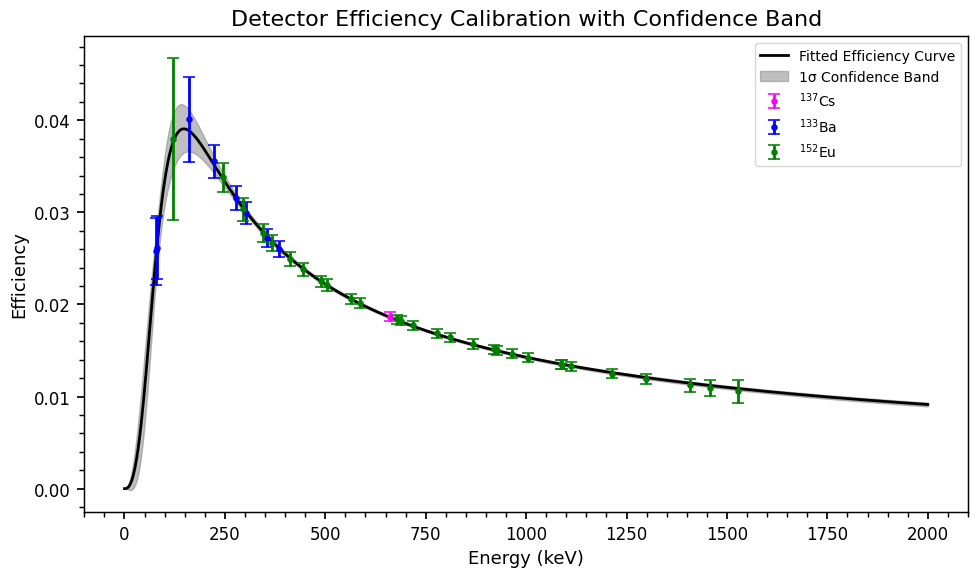

In [4]:
# Extract efficiency data from all spectra
efficiency_data = []
for sp in spectra:
    if sp.peaks is None:
        raise ValueError(f"Peaks not found in spectrum {sp.filename}. Ensure the spectrum is calibrated and has peaks detected.")
    
    for energy, ε, unc_ε, iso_name in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        efficiency_data.append([energy, ε, unc_ε, iso_name])


# Convert to numpy arrays
efficiency_df = pd.DataFrame(efficiency_data, columns=['energy', 'efficiency', 'unc_efficiency', 'isotope'])
isotope_energy_set = efficiency_df['energy'].values
efficiencies = efficiency_df['efficiency'].values
unc_efficiencies = efficiency_df['unc_efficiency'].values


def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)


# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, 
                                        p0=p0, sigma=unc_efficiencies, absolute_sigma=True)

# Generate fitted curve with uncertainties
energy_range = np.linspace(0, 2000, 1000)
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)

# Plotting
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

# Plot data points for each spectrum
colors = ['magenta', 'blue', 'green']
labels = [r'$^{137}$Cs', r'$^{133}$Ba', r'$^{152}$Eu']
for sp, color, label in zip(spectra, colors, labels):
    plt.errorbar(sp.peaks['energy'], sp.peaks['efficiency'], 
                yerr=sp.peaks['unc_efficiency'], fmt='o', label=label, color=color)

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

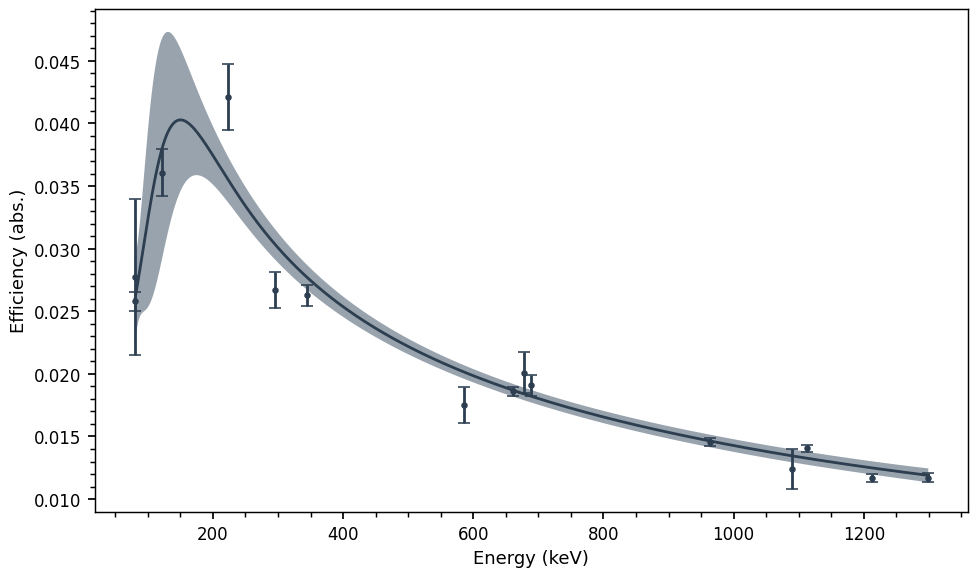

In [5]:
# Plot the efficiency calibration using Curie's built-in function
cb.plot_effcal()

<br><br>

## **Activity Decay Analysis**

#### **Job 1**:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job1_Ag4_1min_real10_loop6_003.Spe
Readin

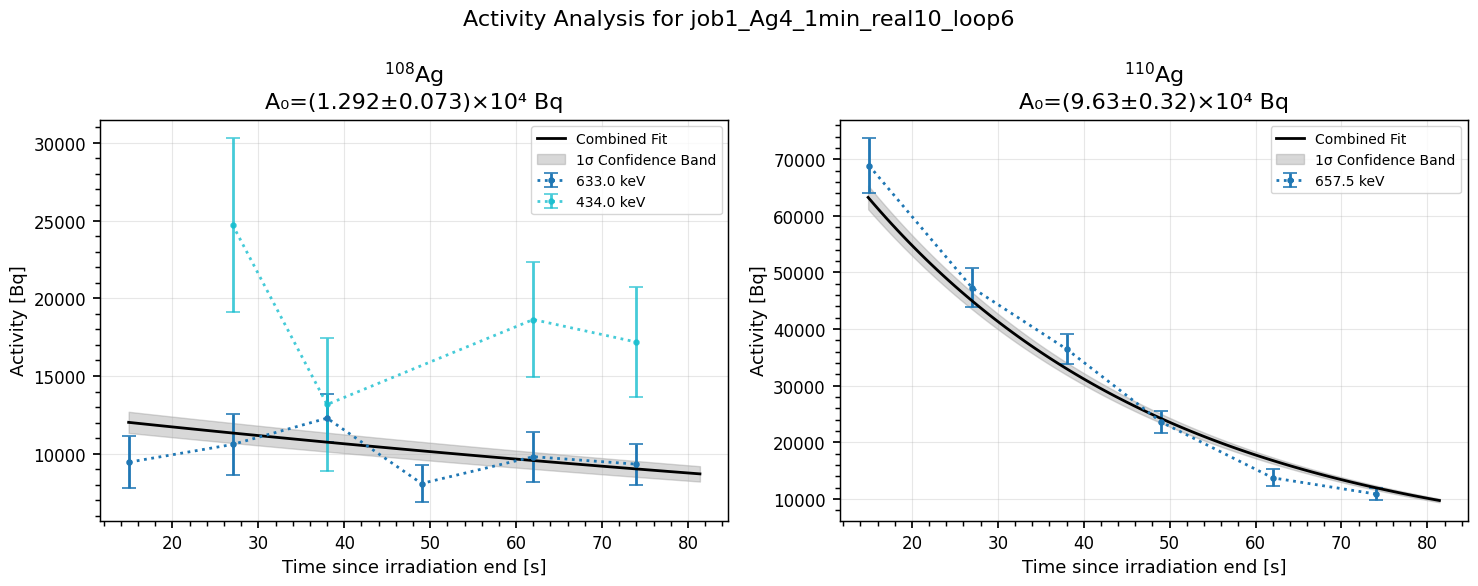

In [6]:
job1_analysis = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)  # type: ignore
job1_analysis.plot_activity()

#### **Job 2**:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job2_Ag10_2min_real30_loop6_003.Spe

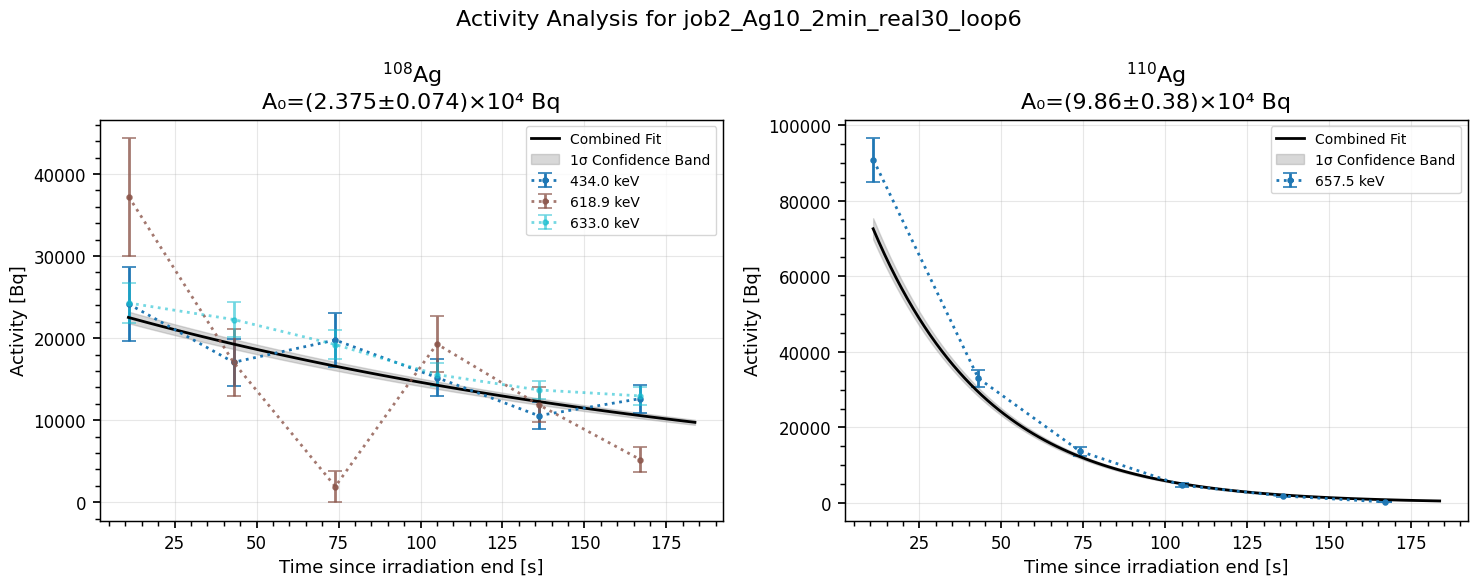

In [7]:
job2_analysis = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)  # type: ignore
job2_analysis.plot_activity()

#### **Job 3:**
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job3_Ag73_3min_real40_loop3_002.Spe


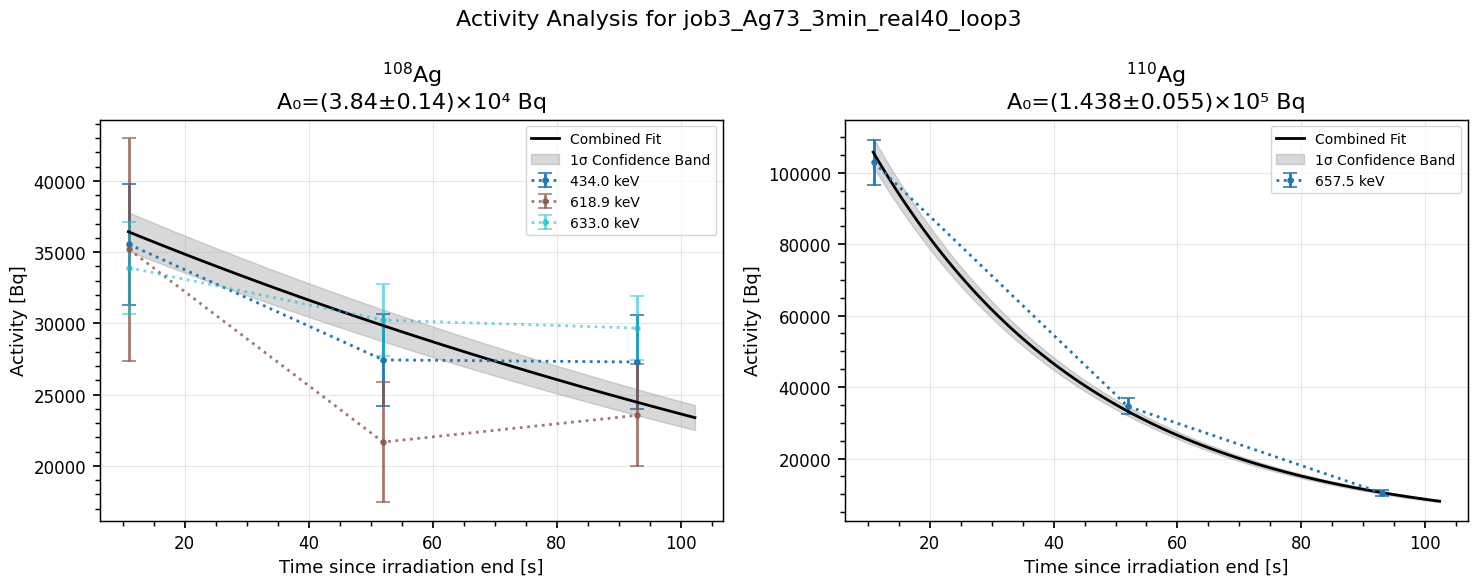

In [8]:
job3_analysis = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)  # type: ignore
job3_analysis.plot_activity()

#### **Job 4:**
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job4_Ag2_3min_real120_loop1_000.Spe


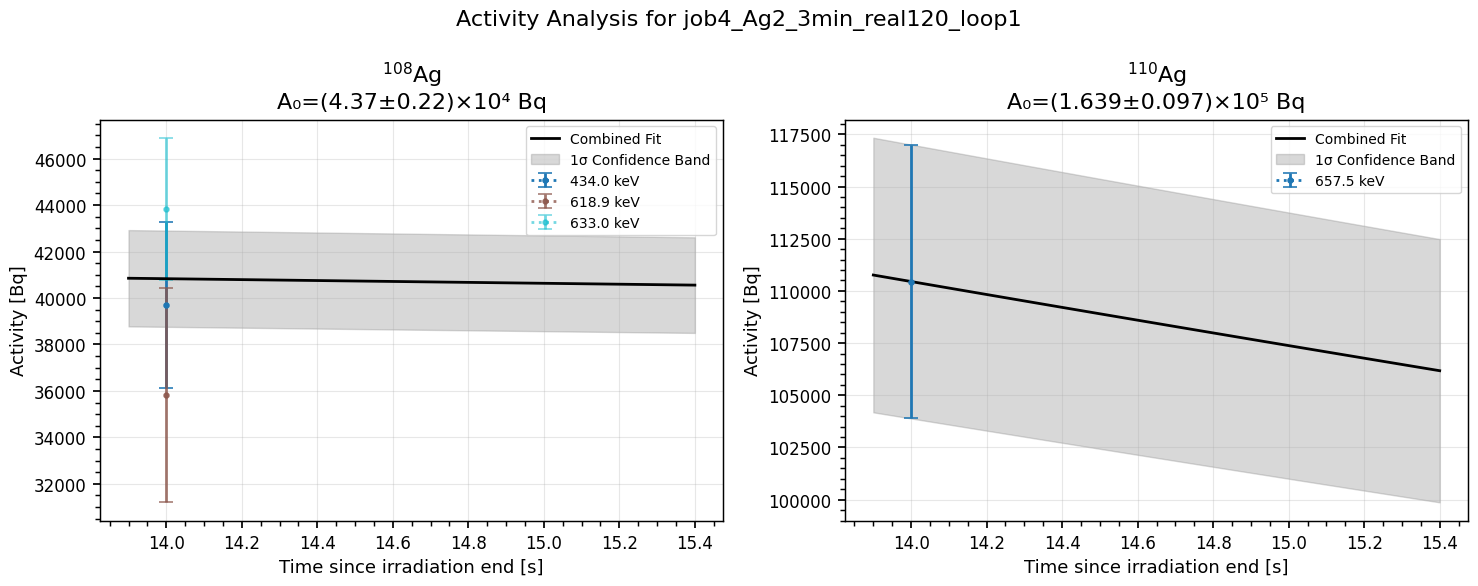

In [9]:
job4_analysis = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)  # type: ignore
job4_analysis.plot_activity()

#### **Job 5:**
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_000.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_001.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_002.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_003.Spe
Reading Spectrum c:\Users\krist\Dokumenter\PRMA\Medical-Applications-of-Nuclear-Physics\spectra\experiment\job5_Ag4_3min_real5_loop6_003.Spe
Reading Spect

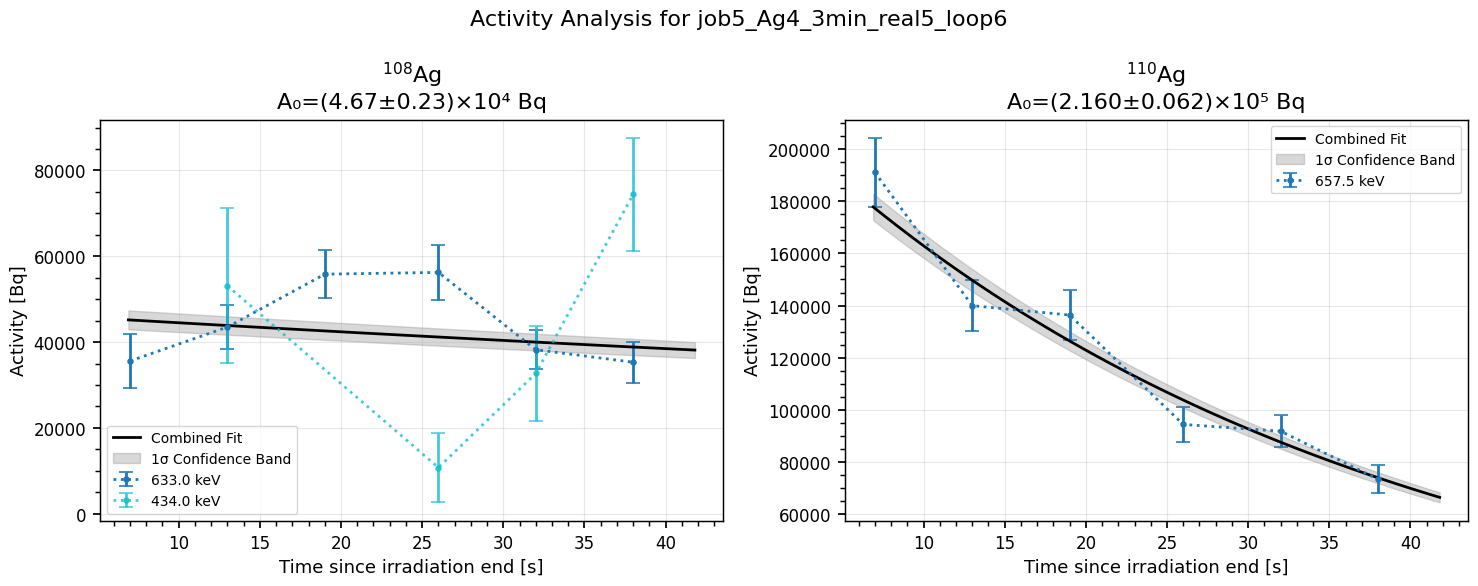

In [10]:
job5_analysis = SpectrumAnalysis(spec_exp_path / 'job5_Ag4_3min_real5_loop6', Δt_d=7)  # type: ignore
job5_analysis.plot_activity()

<br>

#### **Initial Activity and Production Rate Analysis**

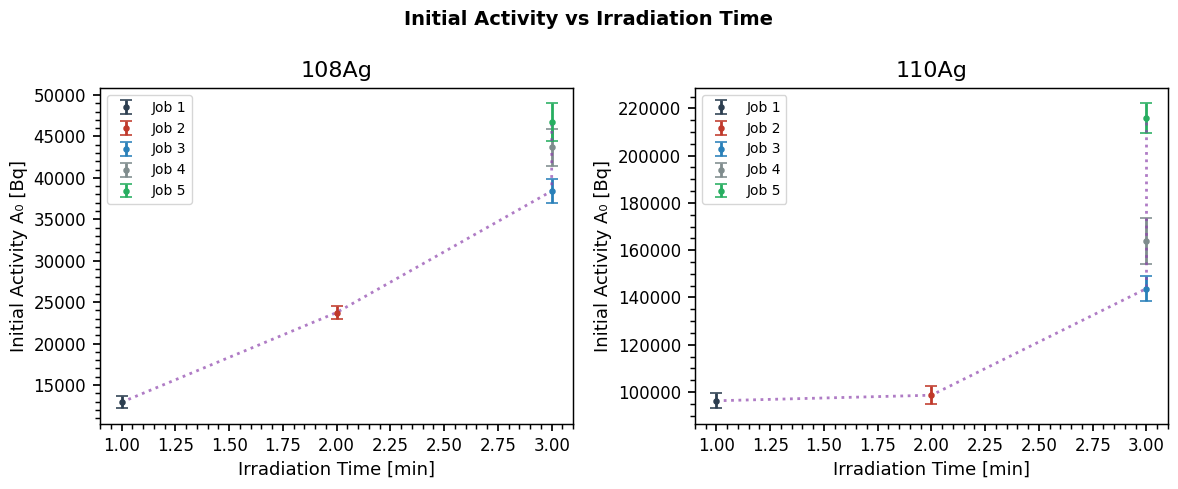

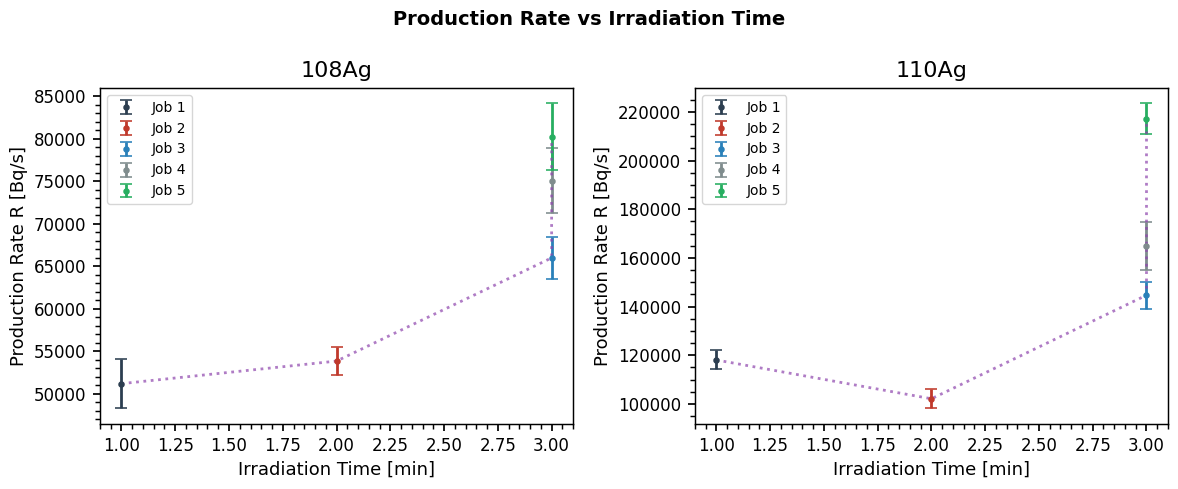

In [11]:
analyses = [job1_analysis, job2_analysis, job3_analysis, job4_analysis, job5_analysis]
job_names = [f"Job {i+1}" for i in range(len(analyses))]
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in analyses]

# Extract data for both isotopes
isotopes = ['108AG', '110AG']
data = {}
for isotope in isotopes:
    data[isotope] = {
        'A0': [analysis.get_isotope_results(isotope).A0.nominal_value for analysis in analyses],  # type: ignore
        'A0_unc': [analysis.get_isotope_results(isotope).A0.std_dev for analysis in analyses],  # type: ignore
        'λ': ci.Isotope(isotope).decay_const()
    }
    # Calculate production rates
    data[isotope]['R'] = [A0 / (1 - np.exp(-data[isotope]['λ'] * irr * 60)) for A0, irr in zip(data[isotope]['A0'], irradiation_times)]
    data[isotope]['R_unc'] = [unc / (1 - np.exp(-data[isotope]['λ'] * irr * 60)) for unc, irr in zip(data[isotope]['A0_unc'], irradiation_times)]


# Create separate plots
plot_configs = [
    ('A0', 'Initial Activity A₀ [Bq]', 'Initial Activity vs Irradiation Time', 'initial_activity_vs_irradiation_time'),
    ('R', 'Production Rate R [Bq/s]', 'Production Rate vs Irradiation Time', 'production_rate_vs_irradiation_time')
]

for metric, ylabel, title, filename in plot_configs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for col, isotope in enumerate(isotopes):
        ax = axes[col]
        
        # Plot data points with error bars
        for irr, val, unc, job in zip(irradiation_times, data[isotope][metric], data[isotope][f'{metric}_unc'], job_names):
            ax.errorbar(irr, val, yerr=unc, fmt='o', label=job)
        
        # Plot connecting line
        ax.plot(irradiation_times, data[isotope][metric], linestyle=':', alpha=0.7)
        
        ax.set_xlabel('Irradiation Time [min]')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{isotope.replace("AG", "Ag")}')
        ax.legend()
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fig_path / 'activity_analysis' / f'{filename}.pdf')
    plt.savefig(fig_path / 'activity_analysis' / f'{filename}.png')
    plt.show()

<br><br>

## **Cross-Section Analysis**

### **Product Nuclide Overview**

This analysis identifies possible radioactive isotopes that can be produced when irradiating our target and monitor foils with protons.

*Target foils:*
  - $^{\text{nat}}\text{Ga}$
  - $^{\text{nat}}\text{Sn}$

*Monitor foils:*
  - $^{\text{nat}}\text{Ni}$
  - $^{\text{nat}}\text{Cu}$

<br>

#### **Target Foils**

**$^{\text{nat}}\text{Ga}$**

In [12]:
csa_Ga = CrossSectionAnalysis(target="Ga", particle_beam="proton", n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)
df_Ga = csa_Ga.isotope_overview(print_markdown=True, copy_to_clipboard=False)

Found 22/63 isotopes for observation:
63Zn 66Ga 71Ge 64Cu 61Cu 65Zn 66Ni 67Ga 70Ga 69Ge 59Fe 68Ge 61Co 66Ge 67Cu 62Zn 67Ge 65Ga 65Ni 69Zn 68Ga 60Co

Found 8/63 grayzone isotopes:
62Fe 64Ge 66Cu 62Co 64Ga 62Cu 61Fe 69Cu


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 72Ge      | Stable      | ✘        |
| 71Ge      | 11 d        | ✔        |
| 70Ge      | Stable      | ✘        |
| 69Ge      | 1.6 d       | ✔        |
| 68Ge      | 2.7e+02 d   | ✔        |
| 67Ge      | 19 m        | ✔        |
| 66Ge      | 2.3 h       | ✔        |
| 65Ge      | 31 s        | ✘        |
| 64Ge      | 1.1 m       | ~        |
| 71Ga      | Stable      | ✘        |
| 70Ga      | 21 m        | ✔        |
| 69Ga      | Stable      | ✘        |
| 68Ga      | 1.1 h       | ✔        |
| 67Ga      | 3.3 d       | ✔        |
| 66Ga      | 9.5 h       | ✔        |
| 65Ga      | 15 m        | ✔        |
| 64Ga      | 2.6 m       | ~        |
| 63Ga      | 32 s        | ✘        |

<br>

**$^{\text{nat}}\text{Sn}$**

In [13]:
csa_Sn = CrossSectionAnalysis(target="Sn")
df_Sn = csa_Sn.isotope_overview(print_markdown=True)

Found 45/133 isotopes for observation:
111Ag 112Ag 102Rh 115Cd 105Rh 105Cd 111In 107In 115Ag 107Cd 115Sb 122Sb 101Rh 113Sn 108Sn 125Sb 120Sb 105Ag 111Sn 103Ag 108In 113Ag 109In 104Cd 124Sb 112In 118Cd 116Sb 109Pd 107Rh 103Pd 104Ag 106Ag 110Sn 112Pd 117Sb 123Sn 110In 121Sn 117Cd 111Pd 117In 109Sn 109Cd 119Sb

Found 17/133 grayzone isotopes:
109Rh 119Cd 114Pd 107Sn 113Sb 114Sb 114In 108Ag 119In 106In 116Ag 111Sb 118Sb 117Ag 113Pd 105In 106Sn


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 125Sb     | 2.8 y       | ✔        |
| 124Sb     | 60 d        | ✔        |
| 123Sb     | Stable      | ✘        |
| 122Sb     | 2.7 d       | ✔        |
| 121Sb     | Stable      | ✘        |
| 120Sb     | 16 m        | ✔        |
| 119Sb     | 1.6 d       | ✔        |
| 118Sb     | 3.6 m       | ~        |
| 117Sb     | 2.8 h       | ✔        |
| 116Sb     | 16 m        | ✔        |
| 115Sb     | 32 m        | ✔        |
| 114Sb     | 3.5 m       | ~        |
| 113Sb 

<br>

#### **Monitor Foils**

**$^{\text{nat}}\text{Cu}$**

In [14]:
csa_Cu = CrossSectionAnalysis(target="Cu")
df_Cu = csa_Cu.isotope_overview(print_markdown=True)

Found 18/63 isotopes for observation:
63Zn 57Co 60Cu 64Cu 61Cu 56Ni 65Zn 54Mn 58Co 56Co 59Fe 57Ni 55Co 61Co 62Zn 56Mn 55Fe 60Co

Found 10/63 grayzone isotopes:
62Fe 59Cu 57Mn 62Co 56Cr 55Cr 62Cu 61Zn 60Zn 61Fe


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 66Zn      | Stable      | ✘        |
| 65Zn      | 2.4e+02 d   | ✔        |
| 64Zn      | Stable      | ✘        |
| 63Zn      | 38 m        | ✔        |
| 62Zn      | 9.3 h       | ✔        |
| 61Zn      | 1.5 m       | ~        |
| 60Zn      | 2.4 m       | ~        |
| 59Zn      | 1.8e+02 ms  | ✘        |
| 58Zn      | 84 ms       | ✘        |
| 65Cu      | Stable      | ✘        |
| 64Cu      | 13 h        | ✔        |
| 63Cu      | Stable      | ✘        |
| 62Cu      | 9.7 m       | ~        |
| 61Cu      | 3.3 h       | ✔        |
| 60Cu      | 24 m        | ✔        |
| 59Cu      | 1.4 m       | ~        |
| 58Cu      | 3.2 s       | ✘        |
| 57Cu      | 2e+02 ms    | ✘        |
| 64Ni  

**$^{\text{nat}}\text{Ni}$**

In [15]:
csa_Ni = CrossSectionAnalysis(target="Ni")
df_Ni = csa_Ni.isotope_overview(print_markdown=True)

Found 24/91 isotopes for observation:
51Mn 54Mn 58Co 56Co 55Fe 57Co 60Cu 47V 52Fe 52Mn 56Ni 61Cu 49V 59Fe 48V 60Co 64Cu 51Cr 49Cr 48Cr 57Ni 55Co 61Co 56Mn

Found 11/91 grayzone isotopes:
62Fe 53Fe 57Mn 62Co 62Cu 61Fe 59Cu 52V 53V 56Cr 55Cr


| Isotope   | Half-life   | Status   |
|:----------|:------------|:---------|
| 65Cu      | Stable      | ✘        |
| 64Cu      | 13 h        | ✔        |
| 63Cu      | Stable      | ✘        |
| 62Cu      | 9.7 m       | ~        |
| 61Cu      | 3.3 h       | ✔        |
| 60Cu      | 24 m        | ✔        |
| 59Cu      | 1.4 m       | ~        |
| 58Cu      | 3.2 s       | ✘        |
| 57Cu      | 2e+02 ms    | ✘        |
| 56Cu      | 94 ms       | ✘        |
| 55Cu      | 40 ms       | ✘        |
| 54Cu      | 75 ns       | ✘        |
| 53Cu      | 3e+02 ns    | ✘        |
| 64Ni      | Stable      | ✘        |
| 63Ni      | 1e+02 y     | ✘        |
| 62Ni      | Stable      | ✘        |
| 61Ni      | Stable      | ✘        |
| 60Ni      | Sta

<br><br>

### **Cross-Section Evaluation**

#### **Target Foils**

##### **Ga**

Found 21/22 isotopes with cross-sections above 0.01 mb:
69Ge 68Ga 67Ga 71Ge 68Ge 65Zn 66Ga 70Ga 67Ge 65Ga 64Cu 63Zn 69Zn 66Ge 62Zn 67Cu 60Co 61Cu 65Ni 61Co 66Ni


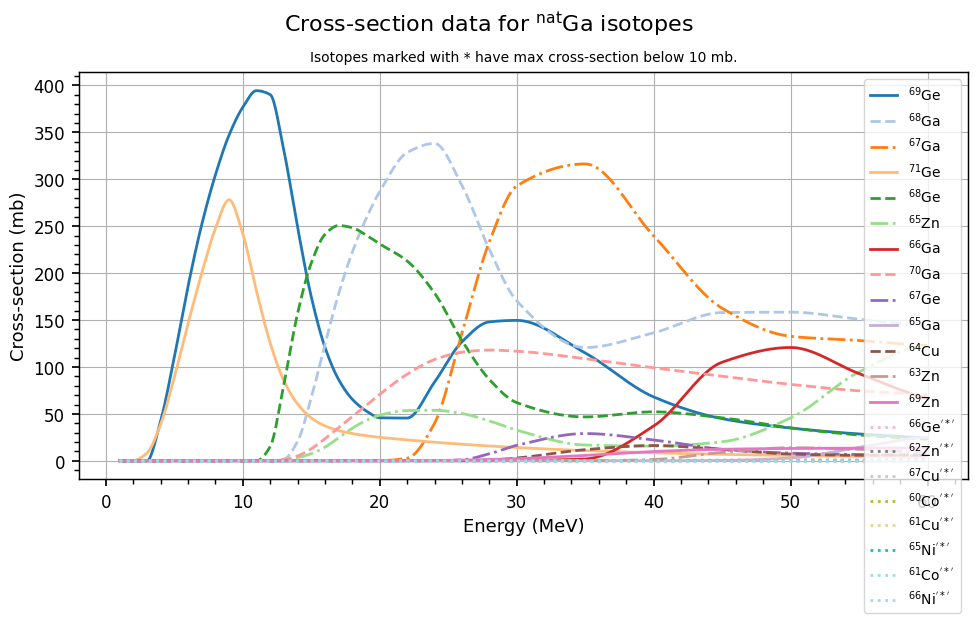

In [16]:
# csa_Ga.save_tendl_data(path = tendl_data_path / "Ga")

# Load the TENDL data for Gallium
(fig_path / "cross_section_analysis").mkdir(parents=True, exist_ok=True)
csa_Ga.load_tendl_data(path = tendl_data_path / "Ga")

# Filter isotopes based on cross-section threshold and energy limit
sorted_filtered_isotopes_Ga = csa_Ga.filter_products_Cs(Cs_threshold=1e-2, E_limit=60, E_beam=None)  # type: ignore
csa_Ga.plot_Cs(title=r"Cross-section data for $^{\text{nat}}$Ga isotopes", isotopes=sorted_filtered_isotopes_Ga, low_Cs_threshold=10)
plt.savefig(fig_path / "cross_section_analysis" / "Ga_filtered_Cs.pdf")
plt.show()

Found 5/8 isotopes with cross-sections above 0.01 mb:
62Cu 66Cu 69Cu 64Ga 62Co


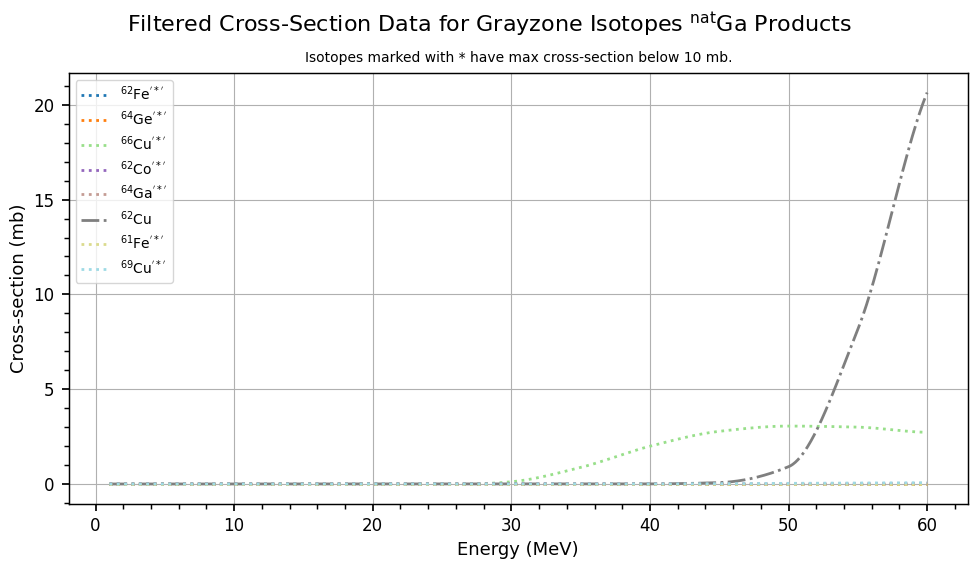

In [17]:
# Load TENDL data
grayzone_products_Ga = csa_Ga.load_tendl_data(path = tendl_data_path / "Ga", isotopes=csa_Ga.grayzone_isotopes)  # type: ignore

# Filter isotopes and plot cross-section data for grayzone isotopes
sorted_filtered_grayzone_isotopes_Ga = csa_Ga.filter_products_Cs(isotopes=grayzone_products_Ga['Name'], Cs_threshold=1e-2, E_limit=60, E_beam=None)  # type: ignore

csa_Ga.plot_Cs(title=r"Filtered Cross-Section Data for Grayzone Isotopes $^{\text{nat}}$Ga Products", isotopes=grayzone_products_Ga)
plt.savefig(fig_path / "cross_section_analysis" / "Ga_grayzone_filtered_Cs.pdf")
plt.show()

<br>

##### **Sn**

Found 31/45 isotopes with cross-sections above 0.01 mb:
119Sb 117Sb 120Sb 116Sb 115Sb 113Sn 122Sb 121Sn 124Sb 117In 123Sn 111Sn 112In 111In 110In 110Sn 109In 109Sn 109Cd 108In 107In 108Sn 107Cd 115Cd 105Cd 125Sb 106Ag 111Ag 117Cd 118Cd 105Ag


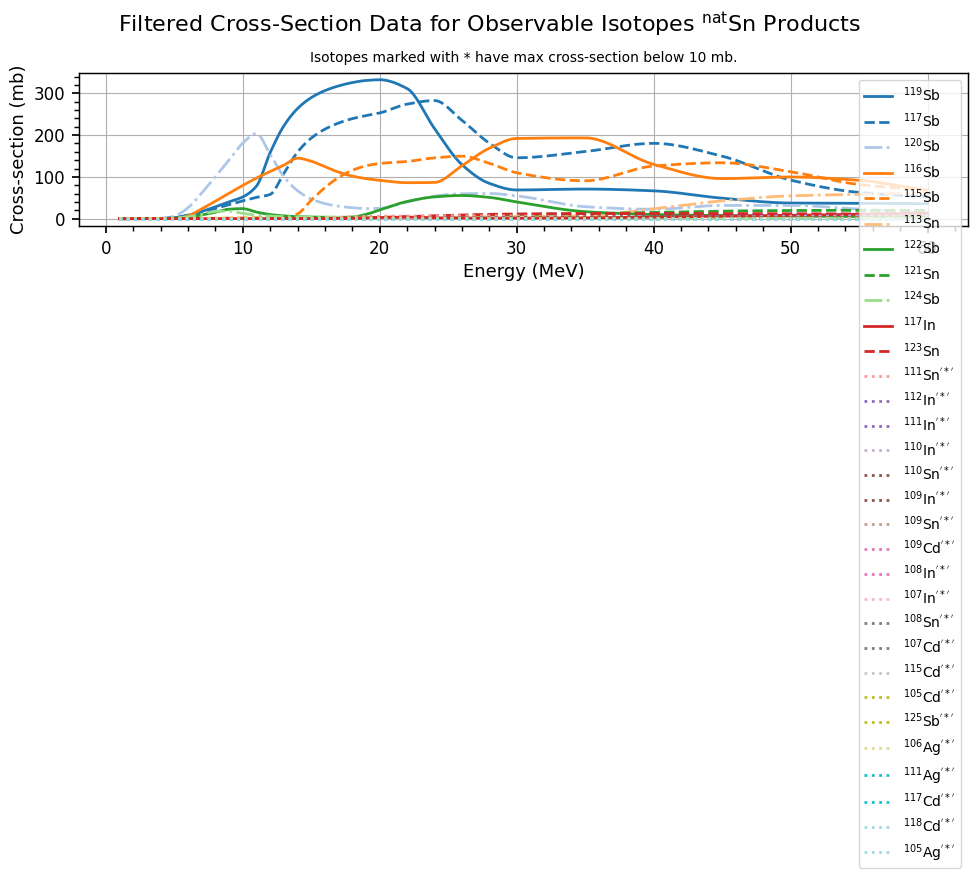

In [18]:
# csa_Sn.save_tendl_data(path = tendl_data_path / "Sn")

# Load the TENDL data for Tin
csa_Sn.load_tendl_data(path = tendl_data_path / "Sn")

# Filter isotopes based on cross-section threshold and energy limit
sorted_filtered_isotopes_Sn = csa_Sn.filter_products_Cs()
csa_Sn.plot_Cs(title=r"Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Sn Products", isotopes=sorted_filtered_isotopes_Sn)
# plt.legend(loc="upper left", ncol=2)
plt.savefig(fig_path /"cross_section_analysis" / "Sn_filtered_Cs.pdf")
plt.show()

<br>

#### **Monitor Foils**

##### **Cu**

Found 18/18 isotopes with cross-sections above 0.01 mb:
63Zn 65Zn 61Cu 64Cu 62Zn 57Co 58Co 60Cu 60Co 56Co 57Ni 55Fe 61Co 54Mn 59Fe 56Mn 56Ni 55Co


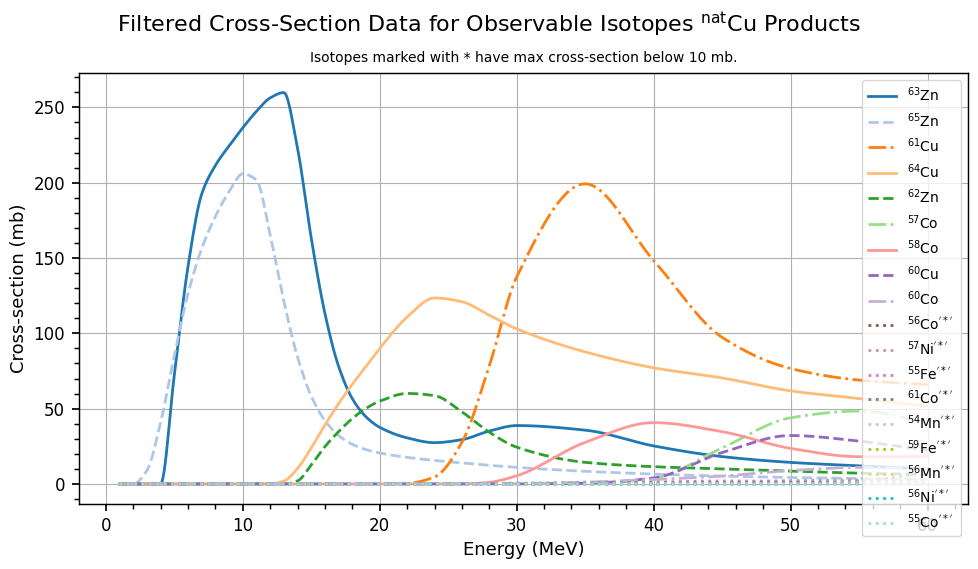

In [19]:
# csa_Cu.save_tendl_data(path = tendl_data_path / 'Cu')

# Load the TENDL data for Copper
csa_Cu.load_tendl_data(path = tendl_data_path / "Cu")

# Filter isotopes based on cross-section threshold and energy limit
sorted_filtered_isotopes_Cu = csa_Cu.filter_products_Cs()
csa_Cu.plot_Cs(title=r"Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Cu Products", isotopes=sorted_filtered_isotopes_Cu)
plt.savefig(fig_path / "cross_section_analysis" / "Cu_filtered_Cs.pdf")
plt.show()

<br>

##### **Ni**

Found 21/24 isotopes with cross-sections above 0.01 mb:
57Co 56Co 57Ni 55Fe 60Cu 58Co 55Co 52Mn 56Ni 61Cu 54Mn 64Cu 60Co 51Cr 61Co 52Fe 51Mn 49V 49Cr 59Fe 56Mn


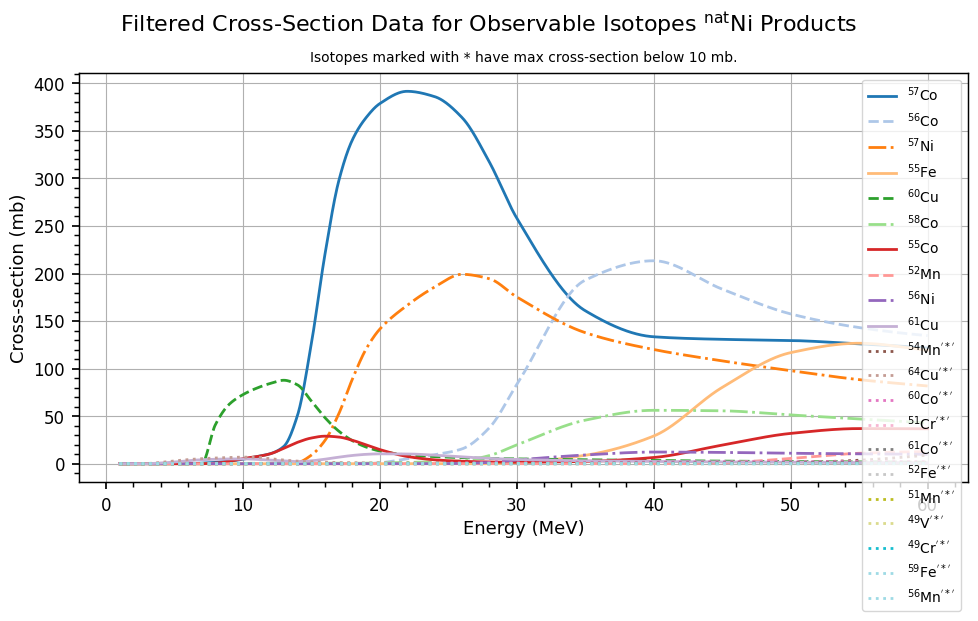

In [20]:
# csa_Ni.save_tendl_data(path = tendl_data_path / 'Ni')

# Load the TENDL data for Nickel
csa_Ni.load_tendl_data(path = tendl_data_path / "Ni")

# Filter isotopes based on cross-section threshold and energy limit
sorted_filtered_isotopes_Ni = csa_Ni.filter_products_Cs()
csa_Ni.plot_Cs(title=r"Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ni Products", isotopes=sorted_filtered_isotopes_Ni)
plt.savefig(fig_path / "cross_section_analysis" / "Ni_filtered_Cs.pdf")
plt.show()

<br><br>

## **Stack Analysis & Counting Time Calculation**


Creating 55_MeV stack...


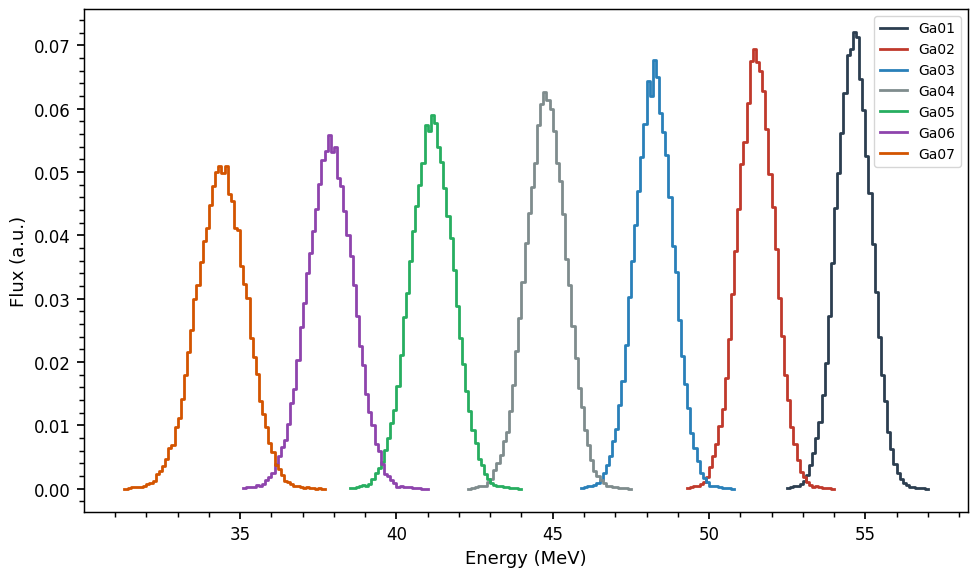

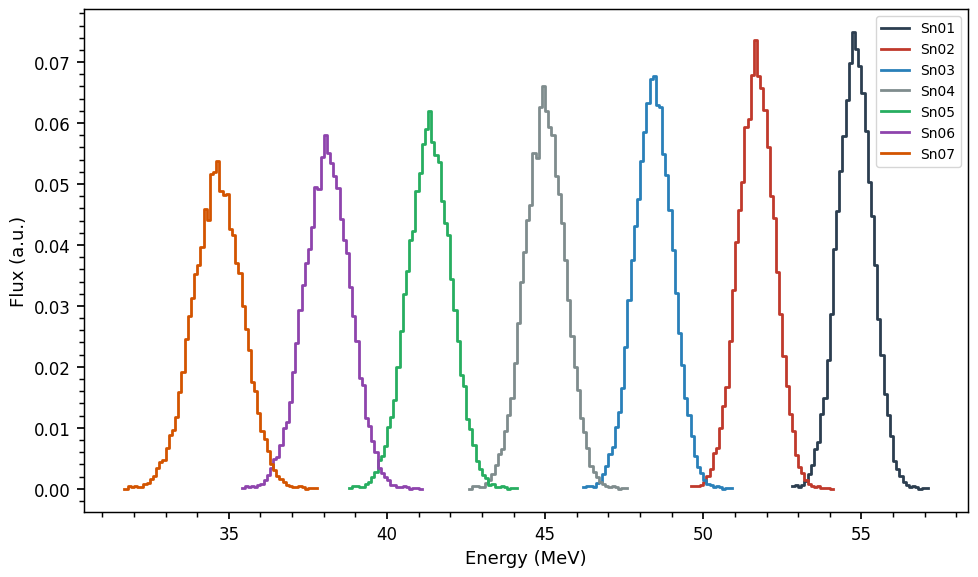


Creating 30_MeV stack...


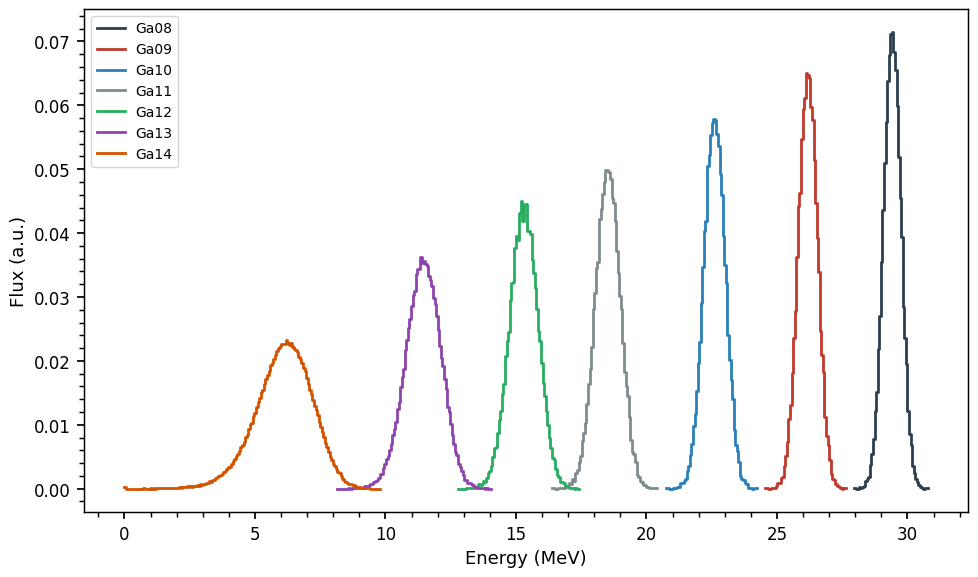

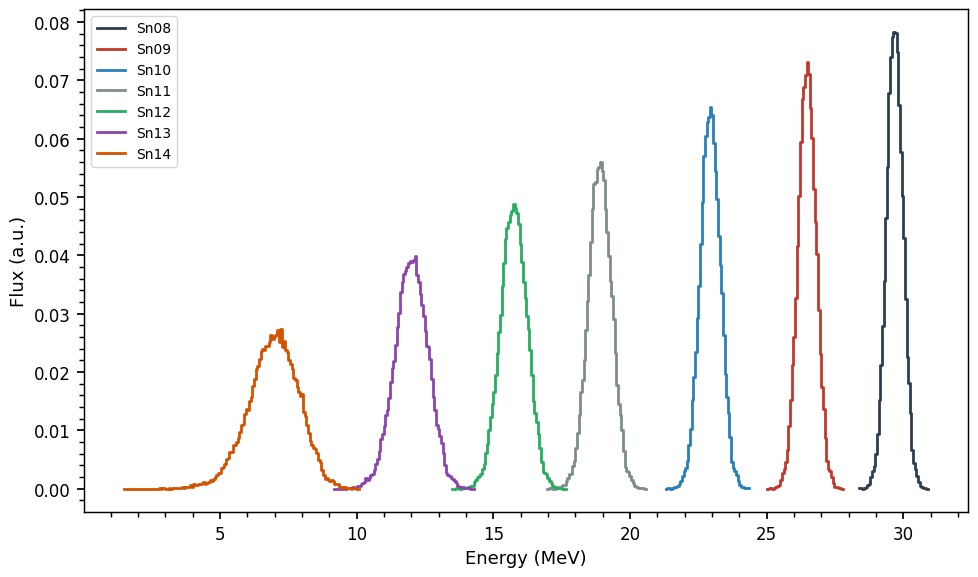

55 MeV stack: 49 layers
30 MeV stack: 49 layers


In [21]:
# Stack configuration parameters
## Units: thickness (mm), mass (g), area (cm²), areal density (mg/cm²), density (g/cm³)

# Material thicknesses
KAPTON_THICKNESS = 0.013
SILICONE_THICKNESS = 0.013

# Aluminum degrader areal densities (mg/cm²)
DEGRADER_CONFIG = {
    'a': 599.0,    # 2.24 mm
    'b': 415.0,    # 1.55 mm  
    'c': 261.5,    # 0.97 mm
    'e': 68.3,     # 0.256 mm
    'h': 33.8
}

# Beryllium backing
BE_BACKING_AD = 4.425  # 23.9130435 microns

# Foil thicknesses (mm)
FOIL_THICKNESS = {
    'Ni': 0.025,
    'Sn': 0.010,
    'Ga': 0.050,
    'Cu': 0.025
}

def create_stack_layer(layer_num, degrader_ad):
    """
    Create a single stack layer with all foils and degrader.

    Parameters
    ----------
    layer_num : int
        The layer number in the stack (used for naming).
    degrader_ad : float
        Areal density of the aluminum degrader (mg/cm²).

    Returns
    -------
    list of dict
        List of dictionaries, each representing a material layer with its properties.
    """
    layer_id = str(layer_num).zfill(2)
    
    return [
        {'compound': 'Ni', 'name': f'Ni{layer_id}', 't': FOIL_THICKNESS['Ni']},
        {'compound': 'Sn', 'name': f'Sn{layer_id}', 't': FOIL_THICKNESS['Sn']},
        {'compound': 'Kapton', 'name': f'Kapton_{layer_id}_front', 't': 2 * KAPTON_THICKNESS},
        {'compound': 'Ga', 'name': f'Ga{layer_id}', 't': FOIL_THICKNESS['Ga']},
        {'compound': 'Kapton', 'name': f'Kapton_{layer_id}_back', 't': 2 * KAPTON_THICKNESS},
        {'compound': 'Cu', 'name': f'Cu{layer_id}', 't': FOIL_THICKNESS['Cu']},
        {'compound': 'Al', 'name': f'Al_degrader_E{layer_id}', 'ad': degrader_ad}
    ]

def build_stack(stack_config):
    """
    Build complete stack from configuration.

    Parameters
    ----------
    stack_config : list of tuple
        Each tuple contains (layer_num, degrader_ad), where
        layer_num : int
            The layer number in the stack.
        degrader_ad : float
            Areal density of the aluminum degrader (mg/cm²).

    Returns
    -------
    list of dict
        List of dictionaries, each representing a material layer with its properties.
    """
    stack = []
    for layer_num, degrader_ad in stack_config:
        stack.extend(create_stack_layer(layer_num, degrader_ad))
    return stack

# Stack configurations
STACK_CONFIGS = {
    '55_MeV': [
        (1, DEGRADER_CONFIG['c']),
        (2, DEGRADER_CONFIG['c']),
        (3, DEGRADER_CONFIG['c']),
        (4, DEGRADER_CONFIG['c']),
        (5, 3 * DEGRADER_CONFIG['e']),
        (6, 3 * DEGRADER_CONFIG['e']),
        (7, 3 * DEGRADER_CONFIG['e'])
    ],
    '30_MeV': [
        (8, 2 * DEGRADER_CONFIG['e']),
        (9, 2 * DEGRADER_CONFIG['e']),
        (10, 2 * DEGRADER_CONFIG['e']),
        (11, DEGRADER_CONFIG['e']),
        (12, DEGRADER_CONFIG['e']),
        (13, 68.75),
        (14, 0.01)
    ]
}

# Stack parameters
STACK_PARAMS = {
    '55_MeV': {'E0': 55.0, 'dE0': 0.55},
    '30_MeV': {'E0': 30.0, 'dE0': 0.30}
}

# Create and analyze both stacks
stacks = {}
for stack_name, config in STACK_CONFIGS.items():
    print(f"\n{'='*25}")
    print(f"Creating {stack_name} stack...")
    print(f"{'='*25}")
    
    # Build stack
    stack = build_stack(config)
    
    # Create Curie stack object
    params = STACK_PARAMS[stack_name]
    st = ci.Stack(
        stack, 
        E0=params['E0'], 
        particle='p', 
        dE0=params['dE0'], 
        N=1e4, 
        max_steps=100
    )
    
    # Store for later use
    stacks[stack_name] = st
    
    # Optional: Save stack data
    # st.saveas(f'lbnl_GaSn_stack_{stack_name}.csv')
    # st.saveas(f'lbnl_GaSn_stack_{stack_name}.db')
    
    # Display stack information
    # print(f"Stack columns: {list(st.stack.columns)}")
    
    # Plot Ga energy distribution
    st.plot("Ga")
    st.plot("Sn")

# Access individual stacks
st_55 = stacks['55_MeV']
st_30 = stacks['30_MeV']

print(f"55 MeV stack: {len(st_55.stack)} layers")
print(f"30 MeV stack: {len(st_30.stack)} layers")

In [22]:
Φ = 6.24e11  # Proton flux in protons/cm^2/s
t_irr = 60 * 60  # Irradiation time in seconds

sa_30 = StackAnalysis(st_30, efficiency_func=cb.eff, proton_flux=Φ, irradiation_time=t_irr)  # type: ignore
sa_55 = StackAnalysis(st_55, efficiency_func=cb.eff, proton_flux=Φ, irradiation_time=t_irr)  # type: ignore

In [55]:
"""
Suppress RuntimeWarnings from stack analysis calculations.
This prevents 'invalid value encountered in log' and 'divide by zero' warnings that occur when 
calculating decay constants for isotopes with very long or very short half-lives.
These warnings are cosmetic and don't affect the validity of the results.
"""

import warnings

# Create time array with 15-minute intervals for 3 days
t_d_15min = np.arange(0, 60*60*24*3, 15*60) 

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    products = {'Ga': sorted_filtered_isotopes_Ga,
                'Sn': sorted_filtered_isotopes_Sn,
                'Cu': sorted_filtered_isotopes_Cu,
                'Ni': sorted_filtered_isotopes_Ni}

    # Calculate counting times using 15-minute intervals
    results_30 = sa_30.analyze(
        products=products, 
        t_d=t_d_15min,  
        t_max=60*60,  # type: ignore
        min_intensity=10.0, 
        dE_511=0.1,  # type: ignore
        silent=True,
    )
    
    results_55 = sa_55.analyze(
        products=products, 
        t_d=t_d_15min,  
        t_max=60*60,  # type: ignore
        min_intensity=10.0, 
        dE_511=0.1,  # type: ignore
        silent=True,
    )

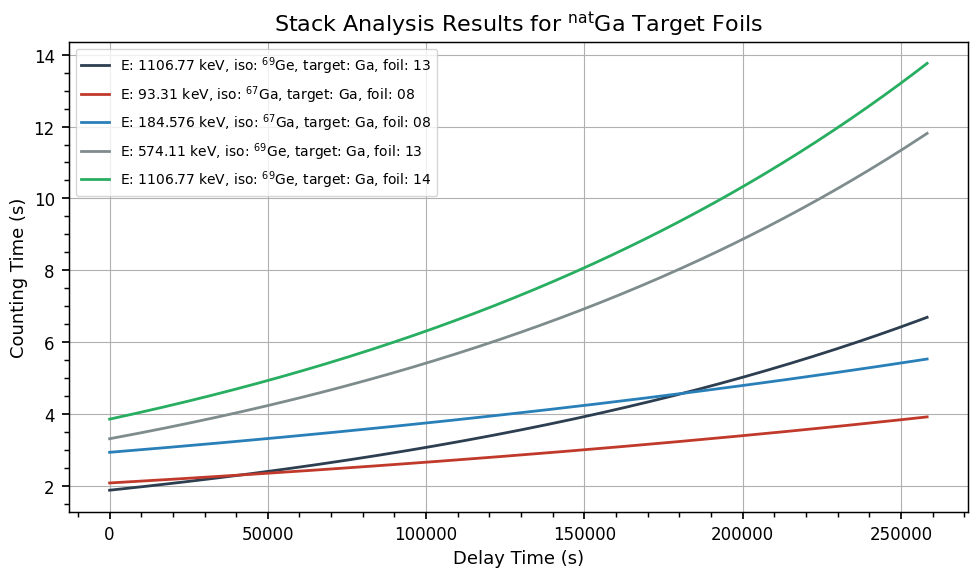

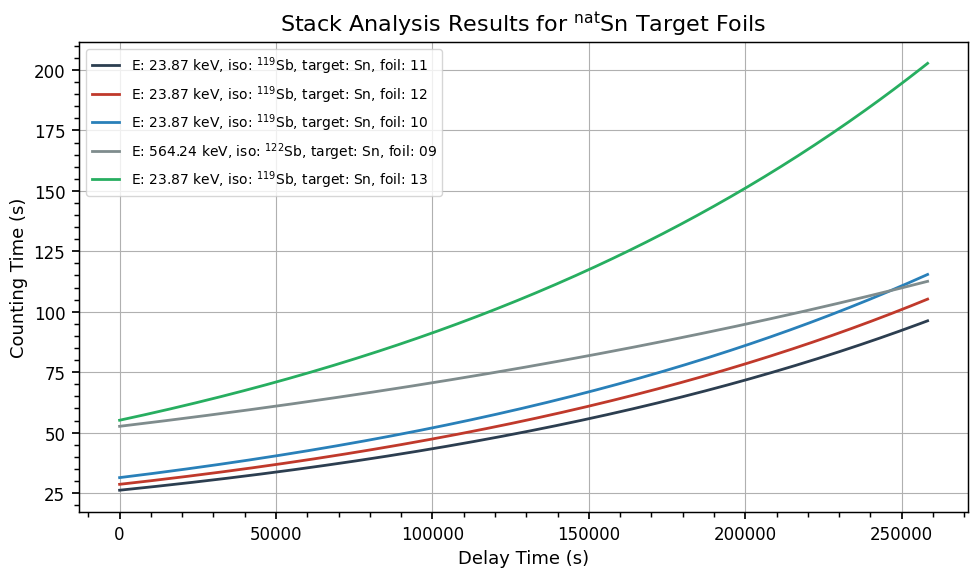

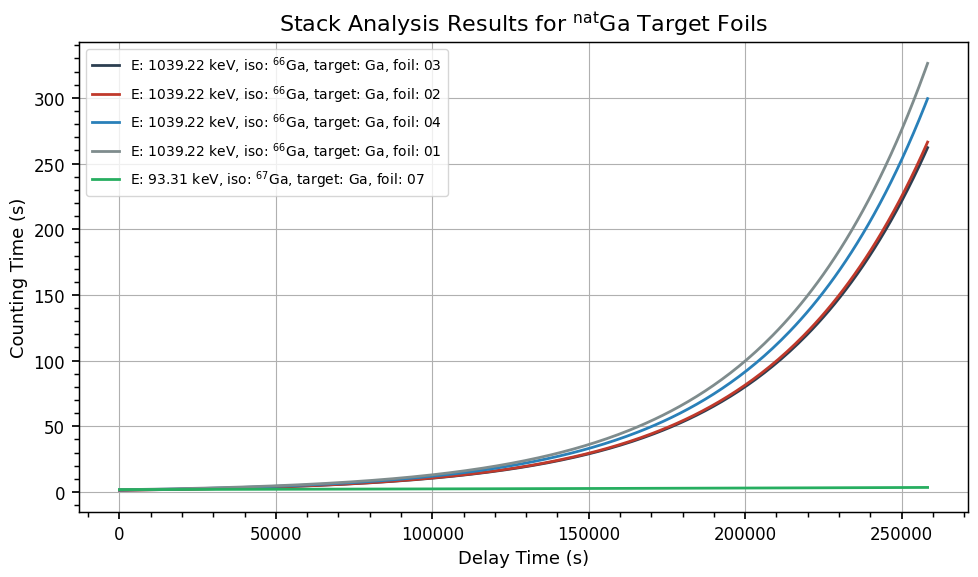

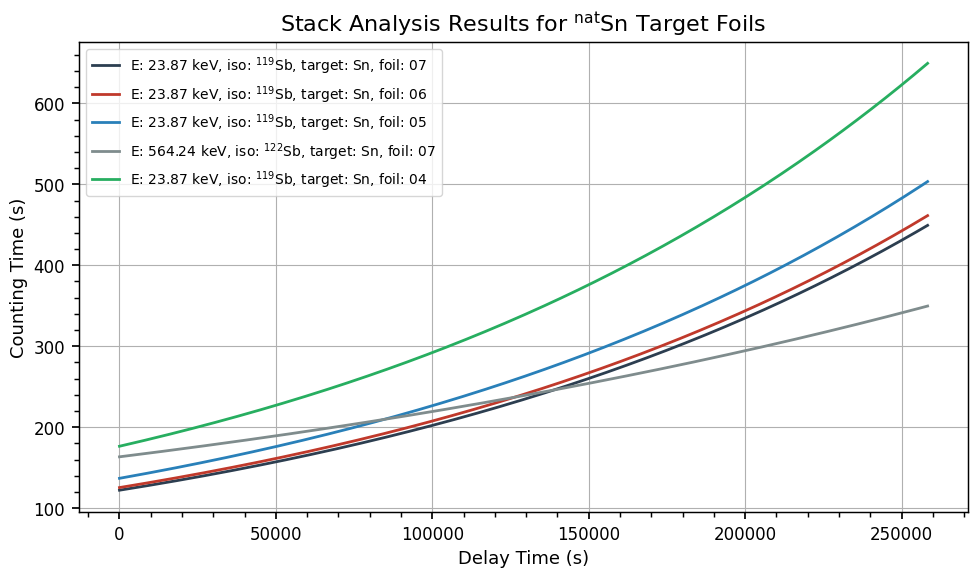

In [60]:
sa_30.plot(results_30, target="Ga", title=r"Stack Analysis Results for $^{\text{nat}}$Ga Target Foils")
plt.show()

sa_30.plot(results_30, target="Sn", title=r"Stack Analysis Results for $^{\text{nat}}$Sn Target Foils")
plt.show()

sa_55.plot(results_55, target="Ga", title=r"Stack Analysis Results for $^{\text{nat}}$Ga Target Foils")
plt.show()

sa_55.plot(results_55, target="Sn", title=r"Stack Analysis Results for $^{\text{nat}}$Sn Target Foils")
plt.show()

In [ ]:
# Set pandas display options for better horizontal spacing
pd.set_option('display.width', 2000)  
pd.set_option('display.precision', 2)  

delay_times = {
    '0s': 0,
    '30min': 30 * 60,
    '1h': 1 * 60 * 60,
    '4h': 4 * 60 * 60,
    '12h': 12 * 60 * 60,
    '24h': 24 * 60 * 60
}

def extract_counting_times_at_delays(results_df, delay_times_dict):
    """
    Extract counting times at specific delay intervals from stack analysis results.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        Stack analysis results containing 't_c' and 't_d' arrays
    delay_times_dict : dict
        Dictionary mapping delay labels to delay times in seconds
        
    Returns
    -------
    pd.DataFrame
        Modified DataFrame with additional columns for counting times at each delay
    """
    df_modified = results_df.copy()
    
    # For each delay time, add a new column with the counting time at that delay
    for delay_label, delay_seconds in delay_times_dict.items():
        counting_times_at_delay = []
        
        for _, row in df_modified.iterrows():
            t_d_array = row['t_d']
            t_c_array = row['t_c']
            
            # Find the index closest to the desired delay time
            delay_idx = np.abs(t_d_array - delay_seconds).argmin()
            t_c_value = t_c_array[delay_idx]
            counting_times_at_delay.append(t_c_value)
        
        df_modified[delay_label] = counting_times_at_delay
    
    return df_modified

# Extract counting times
results_30_with_delays = extract_counting_times_at_delays(results_30, delay_times)
results_55_with_delays = extract_counting_times_at_delays(results_55, delay_times)

# Display columns
columns_to_show = ['isotope', 'target', 'gamma_energy', 'half_life', 'intensity', '0s', '30min', '1h', '4h', '12h', '24h']

print("Counting Times at Different Delay Times")
print("=" * 120)

print("30 MeV Beam:")
print("-" * 80)
print(results_30_with_delays[columns_to_show].head().to_string(index=False, col_space=8))

print("\n\n55 MeV Beam:")
print("-" * 80)
print(results_55_with_delays[columns_to_show].head().to_string(index=False, col_space=8))

Counting Times at Different Delay Times
30 MeV Beam:
--------------------------------------------------------------------------------
 isotope   target  gamma_energy half_life  intensity       0s    30min       1h       4h      12h      24h
    69Ge       Ga       1106.77     1.6 d       0.36     1.87     1.89     1.90     2.01     2.32     2.87
    57Ni       Ni       1377.63     1.5 d       0.82     1.91     1.93     1.95     2.07     2.41     3.05
    67Ga       Ga         93.31     3.3 d       0.39     2.07     2.08     2.09     2.15     2.31     2.56
    57Ni       Ni       1377.63     1.5 d       0.82     2.13     2.15     2.17     2.30     2.69     3.40
    57Ni       Ni       1377.63     1.5 d       0.82     2.15     2.17     2.19     2.32     2.71     3.43


55 MeV Beam:
--------------------------------------------------------------------------------
 isotope   target  gamma_energy half_life  intensity       0s    30min       1h       4h      12h      24h
    66Ga       Ga    